## Aula 02 - Exercícios

In [1]:
import pandas as pd
import numpy as np

### Importar base de dados

In [2]:
import wget
!python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz

100% [....................................................] 65019041 / 65019041
Saved under ml-20m-compact.tar (5).gz
dataset/
dataset/tags_sample.csv
dataset/._.DS_Store
dataset/.DS_Store
dataset/movies_sample.csv
dataset/._genome-tags.csv
dataset/genome-tags.csv
dataset/._ml-youtube.csv
dataset/ml-youtube.csv
dataset/._genome-scores.csv
dataset/genome-scores.csv
dataset/ratings_sample.csv


In [3]:
movies = pd.read_csv('./dataset/movies_sample.csv')
ratings = pd.read_csv('./dataset/ratings_sample.csv')
df = ratings[['userId', 'movieId', 'rating']]
df = df.merge(movies[['movieId', 'title']])
df

,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,11,1046,4.5,Beautiful Thing (1996)
2,11,616,4.0,"Aristocats, The (1970)"
3,11,3535,2.0,American Psycho (2000)
4,11,5669,5.0,Bowling for Columbine (2002)
...,...,...,...,...
190616,138493,288,5.0,Natural Born Killers (1994)
190617,138493,1748,5.0,Dark City (1998)
190618,138493,616,4.0,"Aristocats, The (1970)"
190619,138493,1597,4.5,Conspiracy Theory (1997)


### Mapeamento de ids

In [4]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title


### Divisão da base em treino e teste

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)

**Exercício 01**: Considere o modelo SVD++ visto no final da aula de FC - parte 2. Uma das extensões desse modelo em relação ao SVD otimizado é que ele considera a lista de itens que o usuário forneceu feedback implícito (por exemplo, antes de fornecer uma nota a um filme, ele "navegou" por outros filmes, sem dar nota). Podemos simular essa navegação com a base de dados fornecida considerando como feedback implícito de cada usuário o conjunto de itens que ele avaliou, porém descartando as notas.

***a)*** Implemente a função de treinamento do modelo SVD++.

In [6]:
train

,userId,movieId,rating,title
51276,2985,88,2.5,"Prince & Me, The (2004)"
125583,7302,222,5.0,"Earrings of Madame de..., The (Madame de...) (..."
150073,8729,82,2.0,Australia (2008)
186571,10853,17,3.0,Chasing Amy (1997)
38278,2230,27,3.0,Zero Effect (1998)
...,...,...,...,...
162091,9437,12,4.0,Star Wars: Episode V - The Empire Strikes Back...
175638,10230,16,2.0,Rush Hour 2 (2001)
95816,5556,41,4.5,Dangerous Beauty (1998)
100879,5846,8,2.0,"Karate Kid, The (1984)"


In [7]:
import math

In [8]:
import math

def train_svd_pp(train, n_factors, lr=0.05, reg=0.02, miter=10):

    def _interacted(u):
        """
            Given an userId u, returns a dataframe containing
            only the movies the user has interacted with.
        """
        return train[train['userId'] == u]
    def eta(u):
        """
            Given an userId u, calculates the ammount of 
            items the user has interacted with
        """
        return len(_interacted(u))
    def interacted_movies_by(u):
        """
            Given an userId u, returns a list of unique
            movieIds the user has interacted with
        """
        return _interacted(u)['movieId'].unique()

    def get_implicit_term(u):
        """
            Given an userId u, returns the implicit feedback related
            term for the svd++ prediction. For this, we combine
            the item factors, stored in p, that the user has
            interacted.
        """

        eta_u = eta(u)
        movies_interacted = interacted_movies_by(u)
        implicit_sum = 0
        for movieId in movies_interacted:
            implicit_sum +=  p[movieId]
        return  implicit_sum / math.sqrt(eta_u), eta_u
        
        
    global_mean = train['rating'].mean()
    n_users = df['userId'].max()+1
    n_items = df['movieId'].max()+1

    bu = np.zeros(n_users) # User biases
    bi = np.zeros(n_items) # Item biases
    p = np.random.normal(0.1, 0.1, (n_users, n_factors)) # Users factor matrix
    q = np.random.normal(0.1, 0.1, (n_items, n_factors)) # Items factor matrix

    implicit_factor = np.random.normal(0.1, 0.1, (n_users, n_factors)) # Implicit feedback factors
    error = []
    for t in range(miter):
        sq_error = 0
        j = 0
        print(f"Iniciando iteracao {t} de {miter}")
        for index, row in train.iterrows():
            if (j%1000 == 0):
                print(f"Iteracao {j} de {len(train)}: ({100*(j / len(train)):.2f}%)")
            u = row['userId']
            i = row['movieId']
            implicit_term_u, eta_u = get_implicit_term(u)
            modified_user_factor = p[u] + implicit_term_u
            
            pred = global_mean + bu[u] + bi[i] + np.dot(modified_user_factor, q[i]) 
            
            r_ui = row['rating']
            e_ui = r_ui - pred
            sq_error += e_ui**2

            # Update params
            bu[u] = bu[u] + lr * e_ui - reg*bu[u]
            bi[i] = bi[i] + lr * e_ui - reg*bi[i]
            j+=1
            for f in range(n_factors):
                temp_uf = p[u][f]
                
                implicit_factor[u][f] = implicit_factor[u][f] + lr * ( ( (e_ui * q[i][f])/math.sqrt(eta_u) ) - reg*implicit_factor[u][f])
                p[u][f] = p[u][f] + lr * (e_ui * q[i][f]   - reg * p[u][f])
                q[i][f] = q[i][f] + lr * (e_ui * temp_uf - reg * q[i][f])
        error.append(math.sqrt(sq_error/len(train)))
    print("Treino finalizado!")
    model_params = {"mu": global_mean, "bu": bu, "bi": bi, "p": p, "q": q, "imp_y": implicit_factor}
    return model_params, error

***b)*** Plote a curva de aprendizado de seu modelo.

In [9]:
model_params, err = train_svd_pp(train, 3)

Iniciando iteracao 0 de 10
Iteracao 0 de 152496: (0.00%)
Iteracao 1000 de 152496: (0.66%)
Iteracao 2000 de 152496: (1.31%)
Iteracao 3000 de 152496: (1.97%)
Iteracao 4000 de 152496: (2.62%)
Iteracao 5000 de 152496: (3.28%)
Iteracao 6000 de 152496: (3.93%)
Iteracao 7000 de 152496: (4.59%)
Iteracao 8000 de 152496: (5.25%)
Iteracao 9000 de 152496: (5.90%)
Iteracao 10000 de 152496: (6.56%)
Iteracao 11000 de 152496: (7.21%)
Iteracao 12000 de 152496: (7.87%)
Iteracao 13000 de 152496: (8.52%)
Iteracao 14000 de 152496: (9.18%)
Iteracao 15000 de 152496: (9.84%)
Iteracao 16000 de 152496: (10.49%)
Iteracao 17000 de 152496: (11.15%)
Iteracao 18000 de 152496: (11.80%)
Iteracao 19000 de 152496: (12.46%)
Iteracao 20000 de 152496: (13.12%)
Iteracao 21000 de 152496: (13.77%)
Iteracao 22000 de 152496: (14.43%)
Iteracao 23000 de 152496: (15.08%)
Iteracao 24000 de 152496: (15.74%)
Iteracao 25000 de 152496: (16.39%)
Iteracao 26000 de 152496: (17.05%)
Iteracao 27000 de 152496: (17.71%)
Iteracao 28000 de 1524

In [10]:
from matplotlib import pyplot as plt

In [11]:
err

[0.8877150511805962,
 0.8347176808526621,
 0.8113183751233789,
 0.7953353179807178,
 0.7816659008413199,
 0.7702063460707524,
 0.7614150255574995,
 0.7549422178244927,
 0.7501160209545803,
 0.7465696377298968]

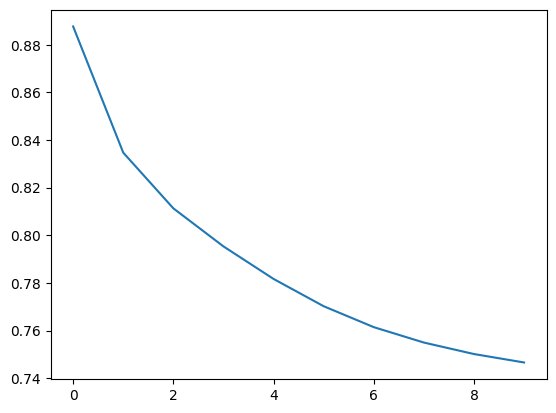

In [12]:
plt.plot(err)
plt.show() 

***c)*** Implemente a função de predição do modelo SVD++, comparando algumas notas preditas com as notas reais do conjunto de teste.

In [13]:
def predict_svd_pp(u, i, model_params):
    global_mean, bu, bi, p, q, imp_y = model_params.values()
    
    modified_user_factor = p[u] + imp_y[u]
    predict = global_mean + bu[u] + bi[i] + np.dot(modified_user_factor, q[i]) 
    return predict

In [15]:
test['predict'] = test.apply(lambda r: predict_svd_pp(r.userId, r.movieId, model_params), axis=1)

In [16]:
test

,userId,movieId,rating,title,predict
31477,1836,60,2.5,She's the Man (2006),2.550924
148621,8646,33,3.5,North by Northwest (1959),3.092657
25190,1464,19,4.5,Reservoir Dogs (1992),5.062966
91518,5315,33,5.0,North by Northwest (1959),2.675693
113446,6571,18,4.0,Life Is Beautiful (La Vita è bella) (1997),3.410172
...,...,...,...,...,...
18611,1083,33,4.0,North by Northwest (1959),2.950817
50787,2952,80,4.5,Fog of War: Eleven Lessons from the Life of Ro...,3.308766
141206,8216,10,4.0,Dark City (1998),4.666571
131571,7648,22,4.0,Natural Born Killers (1994),3.952576


(array([ 544., 1280.,  742., 2910., 2415., 7867., 5454., 9897., 2987.,
        4029.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <BarContainer object of 10 artists>)

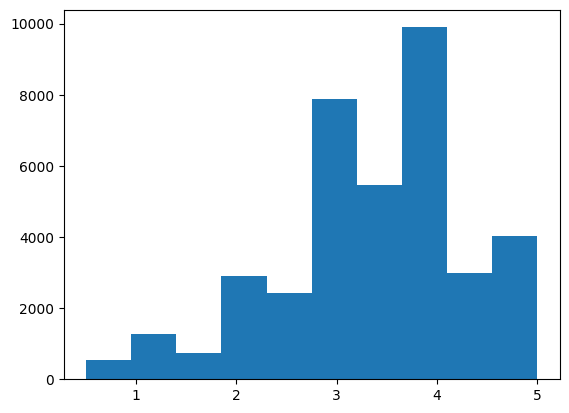

In [17]:
plt.hist(test['rating'])

(array([4.0000e+00, 1.8000e+01, 9.9000e+01, 6.9400e+02, 5.1800e+03,
        2.0644e+04, 1.0519e+04, 8.9600e+02, 6.6000e+01, 5.0000e+00]),
 array([-3.40695457, -2.19509142, -0.98322826,  0.22863489,  1.44049805,
         2.6523612 ,  3.86422436,  5.07608752,  6.28795067,  7.49981383,
         8.71167698]),
 <BarContainer object of 10 artists>)

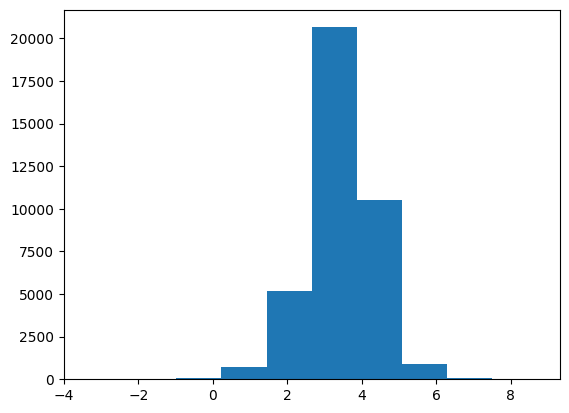

In [18]:
plt.hist(test['predict'])

O modelo não parece ser capaz de aprender notas mais extermas, concentrando as predições em uma faixa intermediária.



**Exercício 02**: Utilizando o código do NCF visto na aula, compare o desempenho entre as instâncias GMF, MLP e NeuMF nesta base de dados (ml-20m-compact).

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [20]:
df_nmf = pd.read_csv('ml-20m-compact/dataset/ratings_sample.csv').rename(columns={"userId": "user_id", "movieId": "item_id"})

# Remover a coluna de timestamp, pois não é necessária
df_nmf = df_nmf.drop('timestamp', axis=1)

# Converter IDs para índices consecutivos (necessário para o PyTorch)
df_nmf['user_id'] = df_nmf['user_id'].astype('category').cat.codes.values
df_nmf['item_id'] = df_nmf['item_id'].astype('category').cat.codes.values

# Converter as avaliações para binárias (1 se rating >= 4, caso contrário 0)
df_nmf['rating'] = (df_nmf['rating'] >= 4).astype(int)

# Dividir os dados em conjuntos de treino e teste
train_data, test_data = train_test_split(df_nmf, test_size=0.2, random_state=42)

# Converter para tensores PyTorch e garantir que sejam do tipo LongTensor
train_users = torch.tensor(train_data['user_id'].values, dtype=torch.long)
train_items = torch.tensor(train_data['item_id'].values, dtype=torch.long)
train_ratings = torch.tensor(train_data['rating'].values).float()

test_users = torch.tensor(test_data['user_id'].values, dtype=torch.long)
test_items = torch.tensor(test_data['item_id'].values, dtype=torch.long)
test_ratings = torch.tensor(test_data['rating'].values).float()

# Criar DataLoader para facilitar o treinamento em mini-batches
train_dataset = data.TensorDataset(train_users, train_items, train_ratings)
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)

In [21]:
import torch
import torch.nn as nn

class GMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, from_nmf=False):
        nn.Module.__init__(self)
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.from_nmf = from_nmf
                 
        if(not from_nmf):
            self.output = nn.Linear(embedding_dim, 1)
            self.sigmoid = nn.Sigmoid()
        
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        
    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        
        output = user_emb * item_emb  # Produto de Hadamard
        
        # Passar pela camada de saída e aplicar sigmoid
        if(not self.from_nmf):
            output = self.sigmoid(self.output(output))
        
        return output


class MLP(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, hidden_layers=[64, 32, 16, 8], from_nmf=False):
        nn.Module.__init__(self)
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        self.from_nmf = from_nmf
        
        layers = []
        input_size = embedding_dim * 2
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size

        if(not from_nmf):
            layers.append(nn.Linear(input_size, 1))
            layers.append(nn.Sigmoid())

        
        self.mlp_layers = nn.Sequential(*layers)
    
    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        mlp_input = torch.cat([user_emb, item_emb], dim=-1)
        mlp_output = self.mlp_layers(mlp_input)
        return mlp_output


In [22]:
class NeuMF(GMF, MLP):
    def __init__(self, num_users, num_items, embedding_dim, hidden_layers=[64, 32, 16, 8], pretrained_gmf=None, pretrained_mlp=None):
        nn.Module.__init__(self)  # Inicializa o nn.Module, necessário em herança múltipla
        GMF.__init__(self, num_users, num_items, embedding_dim, from_nmf=True)
        MLP.__init__(self, num_users, num_items, embedding_dim, hidden_layers, from_nmf=True)
        
        # Camada final para combinar as saídas do GMF e MLP
        combined_input_size = embedding_dim + hidden_layers[-1]
        self.output_layer = nn.Linear(combined_input_size, 1)
        self.sigmoid = nn.Sigmoid()
        
        # Carregar pesos pré-treinados se fornecidos
        if pretrained_gmf:
            self.gmf_user_embedding.weight.data.copy_(pretrained_gmf.user_embedding.weight)
            self.gmf_item_embedding.weight.data.copy_(pretrained_gmf.item_embedding.weight)
        if pretrained_mlp:
            self.mlp_user_embedding.weight.data.copy_(pretrained_mlp.user_embedding.weight)
            self.mlp_item_embedding.weight.data.copy_(pretrained_mlp.item_embedding.weight)
            self.mlp_layers.load_state_dict(pretrained_mlp.mlp_layers.state_dict())
    
    def forward(self, user, item):
        # GMF forward pass
        gmf_output = GMF.forward(self, user, item)
        
        # MLP forward pass
        mlp_output = MLP.forward(self, user, item)
        
        # Concatenar as saídas de GMF e MLP
        combined_output = torch.cat([gmf_output, mlp_output], dim=-1)
        
        # Passar pela camada de saída e aplicar sigmoid
        output = self.sigmoid(self.output_layer(combined_output))
        
        return output


## Treinando o GMF

In [23]:
# Definir os hiperparâmetros
num_users = df_nmf['user_id'].nunique()
num_items = df_nmf['item_id'].nunique()
embedding_dim = 20  # Dimensão das embeddings
hidden_layers = [64, 32, 16, 8]  # Estrutura das camadas ocultas do MLP
learning_rate = 0.001
num_epochs = 20

# Instanciar o modelo NeuMF
#model = NeuMF(num_users, num_items, embedding_dim, hidden_layers)

model_gmf = GMF(num_users, num_items, embedding_dim)

# Definir o otimizador e a função de perda
optimizer = torch.optim.Adam(model_gmf.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()

# Treinamento do modelo
for epoch in range(num_epochs):
    model_gmf.train()
    epoch_loss = 0
    
    for user, item, rating in train_loader:
        optimizer.zero_grad()
        
        # Passar os dados pelo modelo
        prediction = model_gmf(user, item)
        loss = criterion(prediction.squeeze(), rating)
        
        # Backpropagation e atualização dos pesos
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')


Epoch 1/20, Loss: 0.6830
Epoch 2/20, Loss: 0.5519
Epoch 3/20, Loss: 0.4729
Epoch 4/20, Loss: 0.4357
Epoch 5/20, Loss: 0.3954
Epoch 6/20, Loss: 0.3475
Epoch 7/20, Loss: 0.2945
Epoch 8/20, Loss: 0.2398
Epoch 9/20, Loss: 0.1888
Epoch 10/20, Loss: 0.1464
Epoch 11/20, Loss: 0.1135
Epoch 12/20, Loss: 0.0887
Epoch 13/20, Loss: 0.0701
Epoch 14/20, Loss: 0.0561
Epoch 15/20, Loss: 0.0455
Epoch 16/20, Loss: 0.0373
Epoch 17/20, Loss: 0.0309
Epoch 18/20, Loss: 0.0259
Epoch 19/20, Loss: 0.0219
Epoch 20/20, Loss: 0.0186


## Treinando o MLP

In [24]:
# Definir os hiperparâmetros
num_users = df_nmf['user_id'].nunique()
num_items = df_nmf['item_id'].nunique()
embedding_dim = 40  # Dimensão das embeddings
hidden_layers = [64, 32, 16, 8]  # Estrutura das camadas ocultas do MLP
learning_rate = 0.001
num_epochs = 20

# Instanciar o modelo NeuMF
#model = NeuMF(num_users, num_items, embedding_dim, hidden_layers)

model_MLP = MLP(num_users, num_items, embedding_dim)

# Definir o otimizador e a função de perda
optimizer = torch.optim.Adam(model_MLP.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()

# Treinamento do modelo
for epoch in range(num_epochs):
    model_MLP.train()
    epoch_loss = 0
    
    for user, item, rating in train_loader:
        optimizer.zero_grad()
        
        # Passar os dados pelo modelo
        prediction = model_MLP(user, item)
        loss = criterion(prediction.squeeze(), rating)
        
        # Backpropagation e atualização dos pesos
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')


Epoch 1/20, Loss: 0.5796
Epoch 2/20, Loss: 0.5133
Epoch 3/20, Loss: 0.4820
Epoch 4/20, Loss: 0.4651
Epoch 5/20, Loss: 0.4553
Epoch 6/20, Loss: 0.4444
Epoch 7/20, Loss: 0.4309
Epoch 8/20, Loss: 0.4148
Epoch 9/20, Loss: 0.3953
Epoch 10/20, Loss: 0.3731
Epoch 11/20, Loss: 0.3478
Epoch 12/20, Loss: 0.3231
Epoch 13/20, Loss: 0.3006
Epoch 14/20, Loss: 0.2806
Epoch 15/20, Loss: 0.2617
Epoch 16/20, Loss: 0.2399
Epoch 17/20, Loss: 0.2211
Epoch 18/20, Loss: 0.2023
Epoch 19/20, Loss: 0.1833
Epoch 20/20, Loss: 0.1669


## Treinando o NMF

In [26]:
# Definir os hiperparâmetros
num_users = df_nmf['user_id'].nunique()
num_items = df_nmf['item_id'].nunique()
embedding_dim = 20  # Dimensão das embeddings
hidden_layers = [64, 32, 16, 8]  # Estrutura das camadas ocultas do MLP
learning_rate = 0.001
num_epochs = 20

# Instanciar o modelo NeuMF
model = NeuMF(num_users, num_items, embedding_dim, hidden_layers)

# Definir o otimizador e a função de perda
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()

# Treinamento do modelo
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for user, item, rating in train_loader:
        optimizer.zero_grad()
        
        # Passar os dados pelo modelo
        prediction = model(user, item)
        loss = criterion(prediction.squeeze(), rating)
        
        # Backpropagation e atualização dos pesos
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

Epoch 1/20, Loss: 0.5872
Epoch 2/20, Loss: 0.5166
Epoch 3/20, Loss: 0.4866
Epoch 4/20, Loss: 0.4669
Epoch 5/20, Loss: 0.4563
Epoch 6/20, Loss: 0.4490
Epoch 7/20, Loss: 0.4415
Epoch 8/20, Loss: 0.4321
Epoch 9/20, Loss: 0.4198
Epoch 10/20, Loss: 0.4026
Epoch 11/20, Loss: 0.3832
Epoch 12/20, Loss: 0.3627
Epoch 13/20, Loss: 0.3419
Epoch 14/20, Loss: 0.3222
Epoch 15/20, Loss: 0.3041
Epoch 16/20, Loss: 0.2848
Epoch 17/20, Loss: 0.2693
Epoch 18/20, Loss: 0.2517
Epoch 19/20, Loss: 0.2349
Epoch 20/20, Loss: 0.2195


## Avaliando no conjunto teste

In [30]:
model.eval()
model_gmf.eval()
model_MLP.eval()
with torch.no_grad():
    test_prediction_NMF = model(test_users, test_items)
    test_prediction_gmf = model_gmf(test_users, test_items)
    test_prediction_MLP = model_MLP(test_users, test_items)

    
    test_loss_NMF = criterion(test_prediction_NMF.squeeze(), test_ratings)
    test_loss_gmf = criterion(test_prediction_gmf.squeeze(), test_ratings)
    test_loss_MLP = criterion(test_prediction_MLP.squeeze(), test_ratings)
    
    print(f'Test Loss NMF: {test_loss_NMF.item():.4f}')    
    print(f'Test Loss GMF: {test_loss_gmf.item():.4f}')    
    print(f'Test Loss MLP: {test_loss_MLP.item():.4f}')    


Test Loss NMF: 2.4657
Test Loss GMF: 2.4698
Test Loss MLP: 2.1775


O modelo com melhor desempenho foi MLP. 